In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
%matplotlib inline

In [2]:
# Try to get the gpu, if available
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


In [3]:
input_directory = 'Data-MLtutorial/JetDataset/'

# Get a list of all h5 files in the directory
h5_files = [file for file in os.listdir(input_directory) if file.endswith('.h5')]

# Lists to store data
all_images = []
all_targets = []

for h5_file in h5_files:
    file_path = os.path.join(input_directory, h5_file)
    
    with h5py.File(file_path, 'r') as f:
        images = np.array(f['jetImage'], dtype=np.float32)
        images = torch.from_numpy(images)
        images = torch.unsqueeze(images, dim=1)  # add extra dim, needed for CNN
        all_images.append(images)
        
        jet_data = np.array(f['jets'])
        targets = torch.from_numpy(jet_data[:, -6:-1])
        all_targets.append(targets)

# Stack all images and targets from different files
stacked_images = torch.cat(all_images, dim=0)
stacked_targets = torch.cat(all_targets, dim=0)

print("Stacked images shape:", stacked_images.shape)
print("Stacked targets shape:", stacked_targets.shape)

Stacked images shape: torch.Size([80000, 1, 100, 100])
Stacked targets shape: torch.Size([80000, 5])


In [4]:
# Create training and test dataloaders

# how many samples per batch to load
batch_size = 100

# Create a TensorDataset from images and targets
dataset = torch.utils.data.TensorDataset(images, targets)

# Calculate the number of samples in the dataset
dataset_size = len(dataset)

# Define the portion of data to allocate for training
train_ratio = 0.8  # For example, use 80% for training

# Calculate the number of samples for training and testing
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [5]:
# Create the model
import torch.nn as nn
import torch.nn.functional as F


# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)  
        self.conv2 = nn.Conv2d(8, 16, 2, padding=1)

        # pooling layer to reduce x-y dims by two
        self.pool = nn.MaxPool2d(2, 2)
        
        ## Decoder layers ##
        self.deconv1 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(8, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))

        return x

# initialize the NN
model = ConvAutoencoder().to(device)

In [6]:
# specify loss function
criterion = nn.MSELoss()

# specify the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# schedule the learning rate decay
# decay by gamma every step_size
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

Epoch: 10 	Train loss: 242.258380 	Test Loss: 224.065514	Learning rate: 0.01
Epoch: 20 	Train loss: 225.025197 	Test Loss: 214.743648	Learning rate: 0.0095
Epoch: 30 	Train loss: 219.770101 	Test Loss: 209.578722	Learning rate: 0.00903
Epoch: 40 	Train loss: 217.065538 	Test Loss: 205.876711	Learning rate: 0.00857
Epoch: 50 	Train loss: 215.402398 	Test Loss: 205.914319	Learning rate: 0.00815
Epoch: 60 	Train loss: 213.374109 	Test Loss: 204.459327	Learning rate: 0.00774
Epoch: 70 	Train loss: 212.128560 	Test Loss: 203.344004	Learning rate: 0.00735
Epoch: 80 	Train loss: 210.475088 	Test Loss: 201.011097	Learning rate: 0.00698
Epoch: 90 	Train loss: 208.881992 	Test Loss: 199.613787	Learning rate: 0.00663
Epoch: 100 	Train loss: 207.927860 	Test Loss: 196.657294	Learning rate: 0.0063
Epoch: 110 	Train loss: 207.136725 	Test Loss: 195.827927	Learning rate: 0.00599
Epoch: 120 	Train loss: 206.168582 	Test Loss: 195.359148	Learning rate: 0.00569
Epoch: 130 	Train loss: 205.419067 	Test L

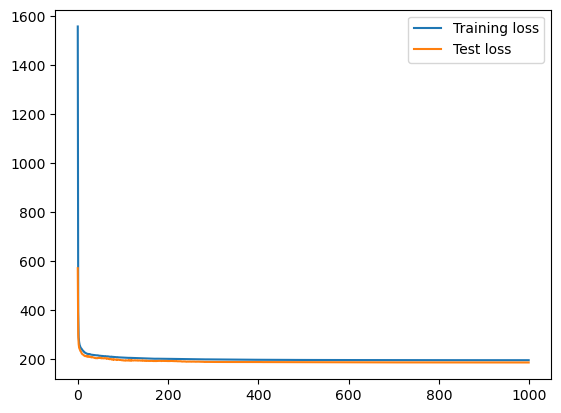

In [7]:
# number of epochs to train the model
n_epochs = 1000
train_losses = []
test_losses = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in train_loader:
        data = data.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)
        # calculate the loss
        loss = criterion(outputs, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

    ###################
    # test the model #
    ################### 
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)
            # calculate the loss
            loss = criterion(outputs, data)
            # update running training loss
            test_loss += loss.item() * data.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    test_loss = test_loss/len(test_loader)
    test_losses.append(test_loss)

    if epoch % 10 == 0:
        print('Epoch: {} \tTrain loss: {:.6f} \tTest Loss: {:.6f}\tLearning rate: {:.3g}'.format(
            epoch, 
            train_loss,
            test_loss,
            scheduler.get_last_lr()[0]
            ))
    scheduler.step()

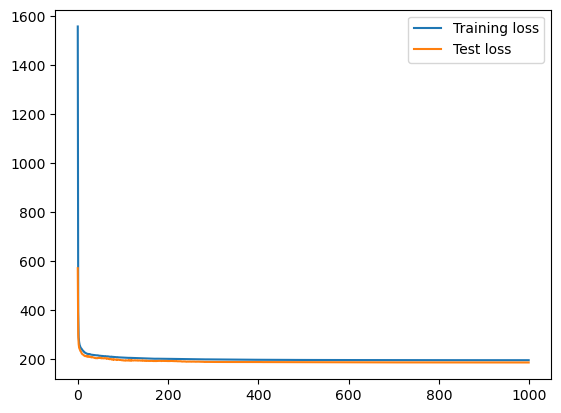

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()

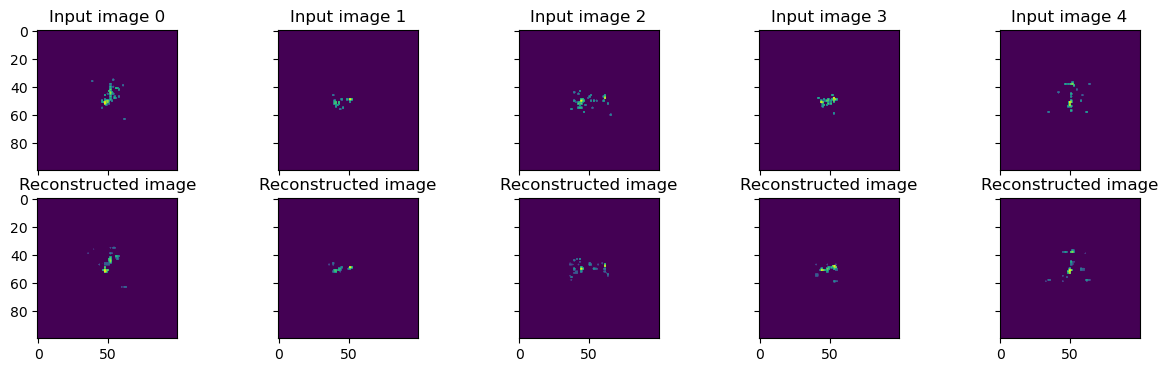

In [11]:
from matplotlib.colors import LogNorm
n_images = 5
# obtain one batch of test images
dataiter = iter(test_loader)
test_images, _ = next(dataiter)
test_images = test_images[:n_images].to(device)

# get sample outputs
output = model(test_images)
# prep images for display
test_images = test_images.cpu().numpy()
# output is resized into a batch of iages
# output = output.view(batch_size, 1, 100, 100)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(n_images*3,4))
# input images on top row, reconstructions on bottom
for i, (input, output) in enumerate(zip(test_images, output)):
    axes[0, i].imshow(np.squeeze(input), norm=LogNorm(vmin=1e-2, clip=True))
    axes[0, i].set_title(f'Input image {i}')
    axes[1, i].imshow(np.squeeze(output), norm=LogNorm(vmin=1e-2, clip=True), label=f'Input image {i}')
    axes[1, i].set_title('Reconstructed image')

plt.savefig('output.png')